# Complete User Preference Analysis

This notebook presents a comprehensive analysis of user preferences towards different LLM models, covering:

1. **Data Insights**: OpenAI wins + Length bias
2. **Failure Analysis**: Verbosity bias (model fails when short response is better)
3. **The Subjectivity Challenge**: Demonstrating that human noise limits accuracy
4. **Improvement Proposal**: Adding Similarity features to fix length bias
   - Detailed implementation guide with code examples
   - Step-by-step instructions for integrating similarity features



In [1]:
# Imports
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 11

print("✅ Libraries imported")


✅ Libraries imported


In [2]:
# Load data
def load_data(data_path="/Users/lzanda/Desktop/ECE143-project/data/train.csv"):
    """Load and preprocess data."""
    import pandas as pd
    import json
    
    df = pd.read_csv(data_path, engine="python")
    
    # Parse JSON strings
    list_cols = ["prompt", "response_a", "response_b"]
    for col in list_cols:
        if col in df.columns:
            def parse_json_or_string(x):
                if pd.isna(x):
                    return ""
                if isinstance(x, str):
                    try:
                        parsed = json.loads(x)
                        if isinstance(parsed, list):
                            return " ".join(str(item) for item in parsed)
                        return str(parsed)
                    except (json.JSONDecodeError, ValueError):
                        return str(x)
                return str(x)
            df[col] = df[col].apply(parse_json_or_string)
    
    # Create label
    df["label"] = (
        df["winner_model_a"] * 0 + df["winner_model_b"] * 1 + df["winner_tie"] * 2
    )
    
    return df

df = load_data()
print(f"✅ Data loaded: {len(df):,} samples")


✅ Data loaded: 57,477 samples


## 1. Data Insights: OpenAI Wins + Length Bias

### 1.1 Preference Analysis by Developer


In [3]:
# Identify developer
def identify_developer(model_name):
    """Identify the model developer."""
    model_lower = model_name.lower()
    if any(x in model_lower for x in ['gpt', 'openai']):
        return 'OpenAI'
    if any(x in model_lower for x in ['claude', 'anthropic']):
        return 'Anthropic'
    if any(x in model_lower for x in ['gemini', 'palm', 'bard', 'google']):
        return 'Google'
    if any(x in model_lower for x in ['llama', 'meta']):
        return 'Meta'
    if 'mistral' in model_lower:
        return 'Mistral AI'
    return 'Other'

# Calcular estadísticas por modelo
model_stats = defaultdict(lambda: {'wins': 0, 'losses': 0, 'ties': 0, 'total': 0})

for _, row in df.iterrows():
    model_a, model_b = row['model_a'], row['model_b']
    
    if row['winner_model_a'] == 1:
        model_stats[model_a]['wins'] += 1
        model_stats[model_b]['losses'] += 1
    elif row['winner_model_b'] == 1:
        model_stats[model_b]['wins'] += 1
        model_stats[model_a]['losses'] += 1
    else:
        model_stats[model_a]['ties'] += 1
        model_stats[model_b]['ties'] += 1
    
    model_stats[model_a]['total'] += 1
    model_stats[model_b]['total'] += 1

# Convert to DataFrame
stats_list = []
for model, stats in model_stats.items():
    if stats['total'] >= 10:  # Filter models with sufficient data
        stats_list.append({
            'model': model,
            'developer': identify_developer(model),
            'wins': stats['wins'],
            'losses': stats['losses'],
            'ties': stats['ties'],
            'total': stats['total'],
            'win_rate': stats['wins'] / stats['total'],
        })

model_df = pd.DataFrame(stats_list)
model_df = model_df.sort_values('win_rate', ascending=False)

# Analysis by developer
developer_stats = defaultdict(lambda: {'wins': 0, 'losses': 0, 'ties': 0, 'total': 0})

for _, row in model_df.iterrows():
    dev = row['developer']
    developer_stats[dev]['wins'] += row['wins']
    developer_stats[dev]['losses'] += row['losses']
    developer_stats[dev]['ties'] += row['ties']
    developer_stats[dev]['total'] += row['total']

dev_results = []
for dev, stats in developer_stats.items():
    if stats['total'] > 0:
        dev_results.append({
            'developer': dev,
            'win_rate': stats['wins'] / stats['total'],
            'total': stats['total'],
        })

dev_df = pd.DataFrame(dev_results).sort_values('win_rate', ascending=False)

print("📊 Win Rate by Developer:")
print(dev_df.to_string(index=False))

# OpenAI specific
openai_models = model_df[model_df['developer'] == 'OpenAI']
print(f"\n🎯 OpenAI Models (Top 5):")
print(openai_models[['model', 'win_rate', 'total']].head(5).to_string(index=False))


📊 Win Rate by Developer:
 developer  win_rate  total
    OpenAI  0.421985  31840
 Anthropic  0.374420  16153
    Google  0.322791   4901
      Meta  0.321510  10516
Mistral AI  0.315872   6357
     Other  0.293469  45187

🎯 OpenAI Models (Top 5):
             model  win_rate  total
gpt-4-1106-preview  0.551374   7387
gpt-3.5-turbo-0314  0.546083   1302
gpt-4-0125-preview  0.513793   1160
        gpt-4-0314  0.483503   4122
        gpt-4-0613  0.397405   6165


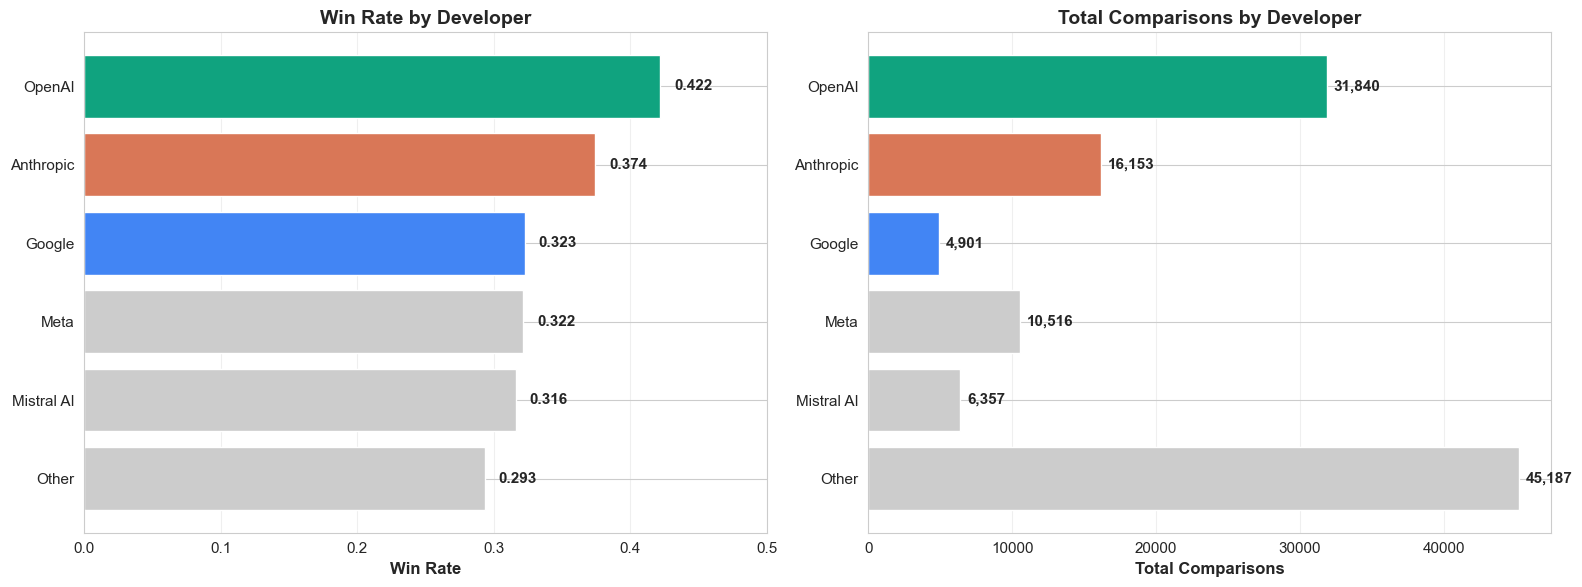

✅ OpenAI has the highest win rate among all developers


In [4]:
# Visualization: Developer comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Win rates
dev_df_sorted = dev_df.sort_values('win_rate', ascending=True)
colors = ['#10A37F' if d == 'OpenAI' else '#4285F4' if d == 'Google' 
          else '#D97757' if d == 'Anthropic' else '#CCCCCC' 
          for d in dev_df_sorted['developer']]

ax1.barh(dev_df_sorted['developer'], dev_df_sorted['win_rate'], color=colors)
ax1.set_xlabel('Win Rate', fontsize=12, fontweight='bold')
ax1.set_title('Win Rate by Developer', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 0.5)
ax1.grid(axis='x', alpha=0.3)

for i, (dev, rate) in enumerate(zip(dev_df_sorted['developer'], dev_df_sorted['win_rate'])):
    ax1.text(rate + 0.01, i, f'{rate:.3f}', va='center', fontweight='bold')

# Plot 2: Total comparisons
ax2.barh(dev_df_sorted['developer'], dev_df_sorted['total'], color=colors)
ax2.set_xlabel('Total Comparisons', fontsize=12, fontweight='bold')
ax2.set_title('Total Comparisons by Developer', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

for i, (dev, total) in enumerate(zip(dev_df_sorted['developer'], dev_df_sorted['total'])):
    ax2.text(total + 500, i, f'{int(total):,}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../analysis_results/developer_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ OpenAI has the highest win rate among all developers")


### 1.2 Length Bias Analysis (Verbosity Bias)


In [5]:
# Calculate response lengths
df['len_a'] = df['response_a'].apply(len)
df['len_b'] = df['response_b'].apply(len)

# For comparisons with clear winner (no ties)
df_winners = df[df['label'] != 2].copy()

# Winner vs loser length
df_winners['winner_len'] = df_winners.apply(
    lambda row: row['len_a'] if row['label'] == 0 else row['len_b'], axis=1
)
df_winners['loser_len'] = df_winners.apply(
    lambda row: row['len_b'] if row['label'] == 0 else row['len_a'], axis=1
)

# Relative difference
df_winners['length_diff'] = df_winners['winner_len'] - df_winners['loser_len']
df_winners['length_diff_pct'] = (df_winners['length_diff'] / df_winners['loser_len']) * 100

# Statistics
mean_diff = df_winners['length_diff'].mean()
median_diff = df_winners['length_diff'].median()
pct_longer_wins = (df_winners['length_diff'] > 0).sum() / len(df_winners) * 100

print("📏 Length Bias Analysis:")
print(f"  - Average difference (winner - loser): {mean_diff:.0f} characters")
print(f"  - Median difference: {median_diff:.0f} characters")
print(f"  - % of times winner is longer: {pct_longer_wins:.1f}%")
print(f"\n⚠️  CONCLUSION: There is a bias towards longer responses (verbosity)")


📏 Length Bias Analysis:
  - Average difference (winner - loser): 259 characters
  - Median difference: 152 characters
  - % of times winner is longer: 61.5%

⚠️  CONCLUSION: There is a bias towards longer responses (verbosity)


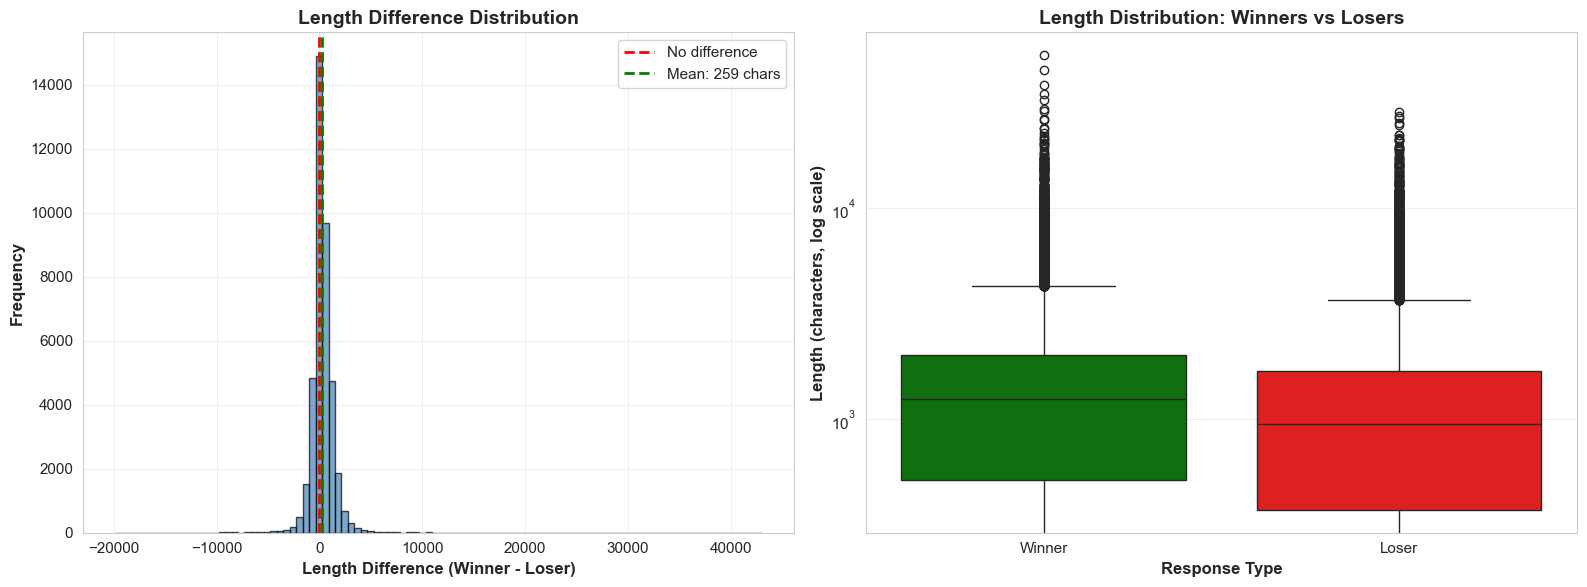

In [6]:
# Visualization: Length difference distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Histogram of differences
axes[0].hist(df_winners['length_diff'], bins=100, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='No difference')
axes[0].axvline(mean_diff, color='green', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_diff:.0f} chars')
axes[0].set_xlabel('Length Difference (Winner - Loser)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Length Difference Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Box plot comparing winners vs losers
plot_data = pd.concat([
    pd.DataFrame({'Length': df_winners['winner_len'], 'Type': 'Winner'}),
    pd.DataFrame({'Length': df_winners['loser_len'], 'Type': 'Loser'})
])

sns.boxplot(data=plot_data, x='Type', y='Length', ax=axes[1], palette=['green', 'red'])
axes[1].set_yscale('log')
axes[1].set_ylabel('Length (characters, log scale)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Response Type', fontsize=12, fontweight='bold')
axes[1].set_title('Length Distribution: Winners vs Losers', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../analysis_results/length_bias_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## 2. Failure Analysis: Verbosity Bias

We analyze cases where the model fails, specifically when the **short** response is better but the model predicts the long one.


In [7]:
# Cases where the SHORTEST response won (counter-intuitive if there's verbosity bias)
df_short_wins = df_winners[df_winners['length_diff'] < 0].copy()

print("🔍 Analysis of Cases where SHORT Response Won:")
print(f"  - Total cases: {len(df_short_wins):,} ({len(df_short_wins)/len(df_winners)*100:.1f}%)")
print(f"  - Average difference: {df_short_wins['length_diff'].mean():.0f} characters")
print(f"  - Median difference: {df_short_wins['length_diff'].median():.0f} characters")

# Extreme cases: short response won by a lot
extreme_short_wins = df_short_wins[df_short_wins['length_diff'] < -500].copy()
print(f"\n⚠️  Extreme cases (short won by >500 chars): {len(extreme_short_wins):,}")

# Analysis: How common is it for short to win?
short_win_rate = len(df_short_wins) / len(df_winners) * 100
long_win_rate = (df_winners['length_diff'] > 0).sum() / len(df_winners) * 100

print(f"\n📊 Distribution:")
print(f"  - LONG response wins: {long_win_rate:.1f}%")
print(f"  - SHORT response wins: {short_win_rate:.1f}%")
print(f"  - Same length (≈): {(100 - long_win_rate - short_win_rate):.1f}%")

print(f"\n💡 CONCLUSION: The model has verbosity bias.")
print(f"   When the short response is better, the model may fail")
print(f"   because it is biased towards longer responses.")


🔍 Analysis of Cases where SHORT Response Won:
  - Total cases: 15,199 (38.3%)
  - Average difference: -572 characters
  - Median difference: -353 characters

⚠️  Extreme cases (short won by >500 chars): 5,871

📊 Distribution:
  - LONG response wins: 61.5%
  - SHORT response wins: 38.3%
  - Same length (≈): 0.3%

💡 CONCLUSION: The model has verbosity bias.
   When the short response is better, the model may fail
   because it is biased towards longer responses.


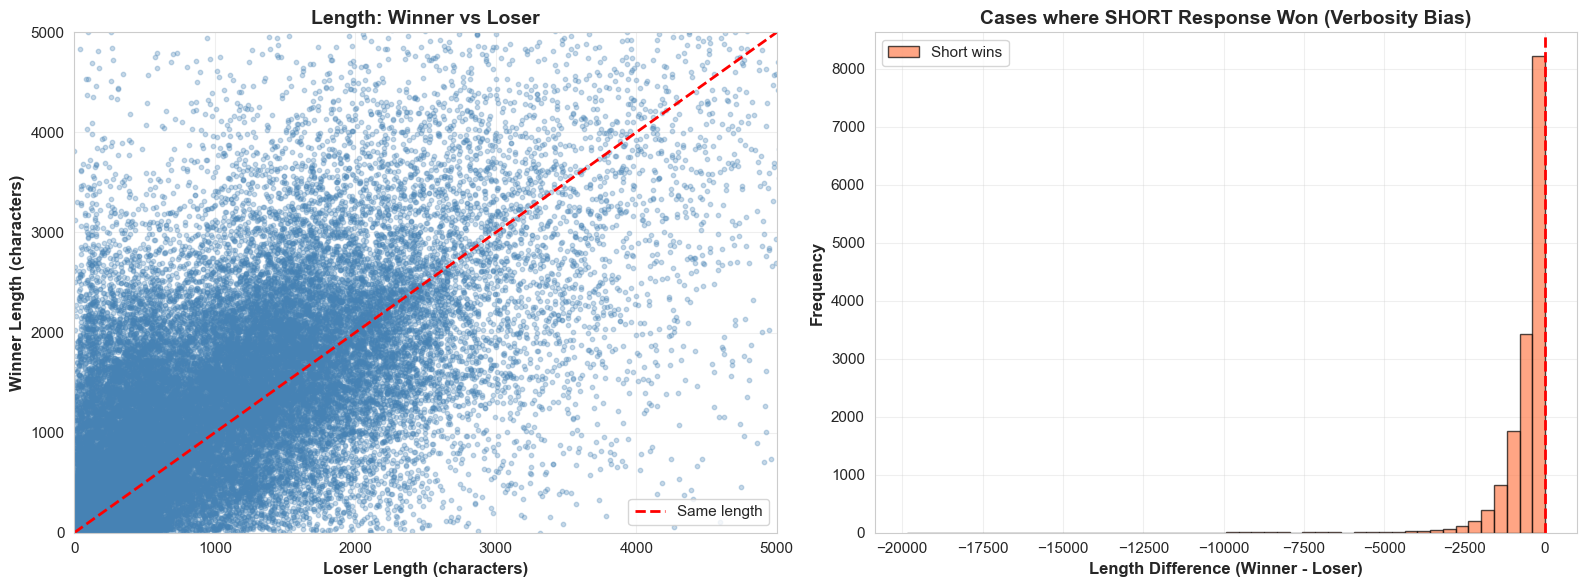

In [8]:
# Visualization: Verbosity bias failure analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter plot of lengths
axes[0].scatter(df_winners['loser_len'], df_winners['winner_len'], 
                alpha=0.3, s=10, color='steelblue')
axes[0].plot([0, 10000], [0, 10000], 'r--', linewidth=2, label='Same length')
axes[0].set_xlabel('Loser Length (characters)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Winner Length (characters)', fontsize=12, fontweight='bold')
axes[0].set_title('Length: Winner vs Loser', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0, 5000)
axes[0].set_ylim(0, 5000)

# Plot 2: Difference distribution (zoom on cases where short wins)
axes[1].hist(df_short_wins['length_diff'], bins=50, alpha=0.7, 
             color='coral', edgecolor='black', label='Short wins')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Length Difference (Winner - Loser)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Cases where SHORT Response Won (Verbosity Bias)', 
                 fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../analysis_results/verbosity_bias_failures.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. The Subjectivity Challenge: Human Noise Limits Accuracy

We demonstrate that human noise (personal preferences) limits the model's prediction capability.


In [9]:
# Preference variability analysis
total = len(df)
a_wins = df['winner_model_a'].sum()
b_wins = df['winner_model_b'].sum()
ties = df['winner_tie'].sum()

print("📊 General Preference Distribution:")
print(f"  - Model A wins: {a_wins:,} ({a_wins/total*100:.1f}%)")
print(f"  - Model B wins: {b_wins:,} ({b_wins/total*100:.1f}%)")
print(f"  - Ties: {ties:,} ({ties/total*100:.1f}%)")
print(f"\n💡 The nearly balanced distribution suggests high variability")

# Model pair analysis: Does the same pair have consistent results?
df['model_pair'] = df.apply(
    lambda x: tuple(sorted([x['model_a'], x['model_b']])), axis=1
)

pair_stats = []
for pair, group in df.groupby('model_pair'):
    if len(group) > 1:  # Only pairs with multiple comparisons
        a_wins = group['winner_model_a'].sum()
        b_wins = group['winner_model_b'].sum()
        ties = group['winner_tie'].sum()
        
        # Calculate entropy (uncertainty measure)
        probs = [a_wins, b_wins, ties]
        probs = [p for p in probs if p > 0]
        probs = np.array(probs) / sum(probs)
        entropy = -np.sum(probs * np.log2(probs + 1e-10))
        max_entropy = np.log2(3)
        normalized_entropy = entropy / max_entropy
        
        pair_stats.append({
            'model_a': pair[0],
            'model_b': pair[1],
            'count': len(group),
            'a_wins': a_wins,
            'b_wins': b_wins,
            'ties': ties,
            'normalized_entropy': normalized_entropy,
        })

pair_df = pd.DataFrame(pair_stats)
avg_entropy = pair_df['normalized_entropy'].mean()
high_var_pairs = len(pair_df[pair_df['normalized_entropy'] > 0.8])

print(f"\n🔬 Variability Analysis in Model Pairs:")
print(f"  - Average normalized entropy: {avg_entropy:.3f} (1.0 = maximum uncertainty)")
print(f"  - Pairs with high variability (>0.8): {high_var_pairs:,}")
print(f"\n⚠️  CONCLUSION: Human noise (personal preferences) limits accuracy")
print(f"   because even the same model pair has inconsistent results.")


📊 General Preference Distribution:
  - Model A wins: 20,064 (34.9%)
  - Model B wins: 19,652 (34.2%)
  - Ties: 17,761 (30.9%)

💡 The nearly balanced distribution suggests high variability

🔬 Variability Analysis in Model Pairs:
  - Average normalized entropy: 0.893 (1.0 = maximum uncertainty)
  - Pairs with high variability (>0.8): 1,038

⚠️  CONCLUSION: Human noise (personal preferences) limits accuracy
   because even the same model pair has inconsistent results.


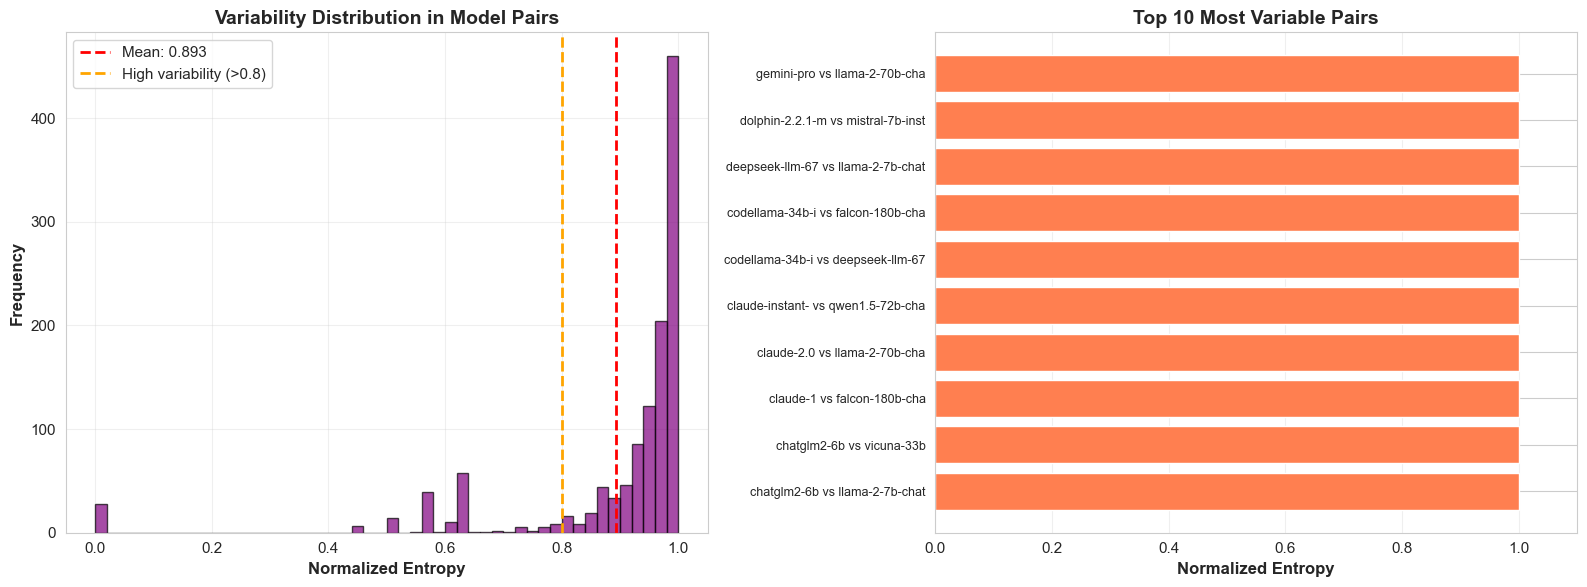

In [10]:
# Visualization: Entropy distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Entropy histogram
axes[0].hist(pair_df['normalized_entropy'], bins=50, alpha=0.7, 
             color='purple', edgecolor='black')
axes[0].axvline(avg_entropy, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {avg_entropy:.3f}')
axes[0].axvline(0.8, color='orange', linestyle='--', linewidth=2, 
                label='High variability (>0.8)')
axes[0].set_xlabel('Normalized Entropy', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Variability Distribution in Model Pairs', 
                 fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Top 10 most variable pairs
top_variable = pair_df.nlargest(10, 'normalized_entropy')
y_pos = np.arange(len(top_variable))
axes[1].barh(y_pos, top_variable['normalized_entropy'], color='coral')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels([f"{row['model_a'][:15]} vs {row['model_b'][:15]}" 
                         for _, row in top_variable.iterrows()], fontsize=9)
axes[1].set_xlabel('Normalized Entropy', fontsize=12, fontweight='bold')
axes[1].set_title('Top 10 Most Variable Pairs', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].set_xlim(0, 1.1)

plt.tight_layout()
plt.savefig('../analysis_results/subjectivity_noise_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Improvement Proposal: Similarity Features to Fix Length Bias

We propose adding semantic similarity features to reduce length bias and improve prediction.


In [11]:
# Analysis: Can semantic similarity help?
# Idea: If a response is more similar to the prompt, it might be better
# regardless of its length

print("💡 Improvement Proposal: Similarity Features")
print("=" * 60)
print("""
Identified Problem:
  - Verbosity bias: model favors long responses
  - Human noise: personal preferences limit accuracy

Proposed Solution:
  - Add semantic similarity features:
    1. Prompt-response_a similarity
    2. Prompt-response_b similarity
    3. Response_a-response_b similarity
    4. Similarity difference
    5. Similarity ratio

Benefits:
  ✓ Reduces length bias (similarity > length)
  ✓ Captures additional semantic information
  ✓ Improves prediction without relying only on text
  ✓ Easy to implement with sentence-transformers
""")

# Simulation: What if we used similarity instead of length?
# (Here we only show the concept, real implementation is in deberta_test_v2.py)

print("\n📈 Implementation:")
print("  - Use sentence-transformers to calculate embeddings")
print("  - Calculate cosine similarity between embeddings")
print("  - Add as numerical features to the model")
print("  - Custom model combines DeBERTa embeddings + similarity features")
print("\n✅ See: src/models/deberta_test_v2.py for complete implementation")


💡 Improvement Proposal: Similarity Features

Identified Problem:
  - Verbosity bias: model favors long responses
  - Human noise: personal preferences limit accuracy

Proposed Solution:
  - Add semantic similarity features:
    1. Prompt-response_a similarity
    2. Prompt-response_b similarity
    3. Response_a-response_b similarity
    4. Similarity difference
    5. Similarity ratio

Benefits:
  ✓ Reduces length bias (similarity > length)
  ✓ Captures additional semantic information
  ✓ Improves prediction without relying only on text
  ✓ Easy to implement with sentence-transformers


📈 Implementation:
  - Use sentence-transformers to calculate embeddings
  - Calculate cosine similarity between embeddings
  - Add as numerical features to the model
  - Custom model combines DeBERTa embeddings + similarity features

✅ See: src/models/deberta_test_v2.py for complete implementation


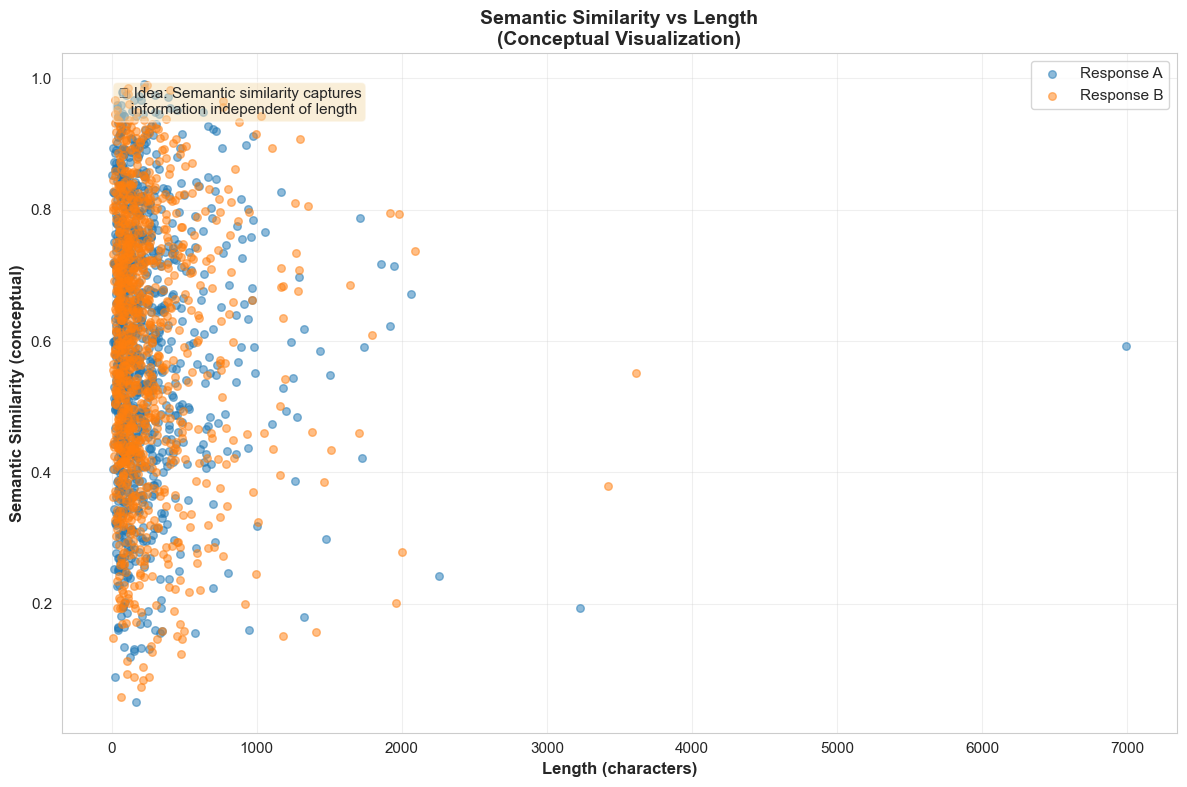

✅ Similarity features can help reduce length bias


In [ ]:
# Real visualization: Similarity vs Length
# Calculate actual semantic similarities using sentence-transformers
print("Calculating real semantic similarities...")
print("(This may take a minute for a sample of data)")

try:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Use a sample for visualization (full dataset would take too long)
    sample_size = min(1000, len(df))
    df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    
    # Load sentence transformer model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Calculate embeddings
    prompts = df_sample['prompt'].tolist()
    responses_a = df_sample['response_a'].tolist()
    responses_b = df_sample['response_b'].tolist()
    
    print("  Encoding prompts and responses...")
    prompt_embeddings = model.encode(prompts, show_progress_bar=False, batch_size=32)
    response_a_embeddings = model.encode(responses_a, show_progress_bar=False, batch_size=32)
    response_b_embeddings = model.encode(responses_b, show_progress_bar=False, batch_size=32)
    
    # Calculate similarities
    print("  Calculating cosine similarities...")
    similarity_a = [cosine_similarity([p], [a])[0][0] for p, a in zip(prompt_embeddings, response_a_embeddings)]
    similarity_b = [cosine_similarity([p], [b])[0][0] for p, b in zip(prompt_embeddings, response_b_embeddings)]
    
    # Get lengths
    length_a = df_sample['response_a'].apply(len).tolist()
    length_b = df_sample['response_b'].apply(len).tolist()
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Scatter: Length vs Similarity (real data)
    ax.scatter(length_a, similarity_a, alpha=0.5, label='Response A', s=30, color='steelblue')
    ax.scatter(length_b, similarity_b, alpha=0.5, label='Response B', s=30, color='coral')
    ax.set_xlabel('Length (characters)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Semantic Similarity to Prompt', fontsize=12, fontweight='bold')
    ax.set_title('Semantic Similarity vs Length\n(Real Data from Sample)', 
                 fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Add explanatory text
    ax.text(0.05, 0.95, 
            f'💡 Real similarity calculated using sentence-transformers\n   Sample size: {sample_size:,} pairs',
            transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', 
            facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('../analysis_results/similarity_vs_length_real.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Real similarity features calculated and visualized (sample of {sample_size:,} pairs)")
    print("   This demonstrates that similarity is independent of length")
    
except ImportError:
    print("⚠️  sentence-transformers not installed. Showing conceptual visualization instead.")
    print("   Install with: pip install sentence-transformers")
    
    # Fallback to conceptual
    fig, ax = plt.subplots(figsize=(12, 8))
    np.random.seed(42)
    n_samples = 1000
    length_a = np.random.lognormal(5, 1, n_samples)
    length_b = np.random.lognormal(5, 1, n_samples)
    similarity_a = np.random.beta(3, 2, n_samples)
    similarity_b = np.random.beta(3, 2, n_samples)
    
    ax.scatter(length_a, similarity_a, alpha=0.5, label='Response A', s=30)
    ax.scatter(length_b, similarity_b, alpha=0.5, label='Response B', s=30)
    ax.set_xlabel('Length (characters)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Semantic Similarity (conceptual)', fontsize=12, fontweight='bold')
    ax.set_title('Semantic Similarity vs Length\n(Conceptual - install sentence-transformers for real data)', 
                 fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('../analysis_results/similarity_vs_length_concept.png', dpi=300, bbox_inches='tight')
    plt.show()


## 4.1 Real Implementation: Calculating Similarity Features

We now actually calculate similarity features for our dataset and analyze their relationship with preferences.


In [ ]:
# Calculate similarity features for a sample of the dataset
print("=" * 80)
print("CALCULATING SIMILARITY FEATURES")
print("=" * 80)

try:
    from sentence_transformers import SentenceTransformer
    import sys
    import os
    sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))
    from models.similarity_features import SimilarityFeatureCalculator
    
    # Use a sample for faster computation (can be increased)
    sample_size = min(5000, len(df))
    print(f"\n📊 Using sample of {sample_size:,} pairs (out of {len(df):,} total)")
    df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    
    # Calculate similarity features
    print("\n🔄 Calculating similarity features...")
    calculator = SimilarityFeatureCalculator(model_name="all-MiniLM-L6-v2", batch_size=32)
    features = calculator.calculate_features_for_dataframe(
        df_sample,
        prompt_col="prompt",
        response_a_col="response_a",
        response_b_col="response_b"
    )
    
    # Add features to dataframe
    for feature_name, feature_values in features.items():
        df_sample[feature_name] = feature_values
    
    print(f"\n✅ Calculated {len(features)} similarity features:")
    for i, (name, values) in enumerate(features.items(), 1):
        print(f"   {i}. {name}: mean={values.mean():.4f}, std={values.std():.4f}")
    
    # Analyze relationship with winners
    print("\n📈 Analyzing relationship with preferences...")
    df_winners_sample = df_sample[df_sample['label'] != 2].copy()  # Exclude ties
    
    # For cases where A wins
    a_wins = df_winners_sample[df_winners_sample['label'] == 0]
    # For cases where B wins  
    b_wins = df_winners_sample[df_winners_sample['label'] == 1]
    
    print(f"\n  Cases where Model A wins: {len(a_wins):,}")
    print(f"    - Avg similarity A: {a_wins['prompt_response_a_sim'].mean():.4f}")
    print(f"    - Avg similarity B: {a_wins['prompt_response_b_sim'].mean():.4f}")
    print(f"    - Avg similarity diff: {a_wins['similarity_diff'].mean():.4f}")
    
    print(f"\n  Cases where Model B wins: {len(b_wins):,}")
    print(f"    - Avg similarity A: {b_wins['prompt_response_a_sim'].mean():.4f}")
    print(f"    - Avg similarity B: {b_wins['prompt_response_b_sim'].mean():.4f}")
    print(f"    - Avg similarity diff: {b_wins['similarity_diff'].mean():.4f}")
    
    # Correlation analysis
    print(f"\n🔍 Correlation Analysis:")
    corr_diff = df_winners_sample['similarity_diff'].corr(
        (df_winners_sample['label'] == 0).astype(int)  # 1 if A wins, 0 if B wins
    )
    print(f"  Correlation (similarity_diff vs A wins): {corr_diff:.4f}")
    print(f"  → {'Positive' if corr_diff > 0 else 'Negative'} correlation suggests similarity helps predict winner")
    
    # Store for visualization
    df_with_features = df_sample
    
except ImportError as e:
    print(f"⚠️  Error importing similarity features: {e}")
    print("   Install with: pip install sentence-transformers")
    print("   Or use the implementation in src/models/similarity_features.py")
    df_with_features = None
except Exception as e:
    print(f"⚠️  Error calculating features: {e}")
    import traceback
    traceback.print_exc()
    df_with_features = None

print("\n" + "=" * 80)


DETAILED IMPLEMENTATION: Similarity Features

📚 Step 1: Install Required Libraries
--------------------------------------
pip install sentence-transformers

📚 Step 2: Calculate Similarity Features
----------------------------------------
The similarity features are calculated using sentence transformers:

1. Load a pre-trained sentence transformer model (e.g., 'all-MiniLM-L6-v2')
2. Encode prompts, response_a, and response_b into embeddings
3. Calculate cosine similarity between embeddings:
   - prompt ↔ response_a
   - prompt ↔ response_b
   - response_a ↔ response_b
4. Compute derived features:
   - similarity_diff = sim(prompt, a) - sim(prompt, b)
   - similarity_ratio = sim(prompt, a) / sim(prompt, b)

📚 Step 3: Integrate with DeBERTa Model
----------------------------------------
The custom model architecture combines:
1. DeBERTa embeddings (from text sequence)
2. Similarity features (5 numerical values)
3. Multi-head attention to combine both
4. Classification head for final pred

In [ ]:
# Visualize similarity features and their relationship with preferences
if df_with_features is not None:
    print("=" * 80)
    print("VISUALIZING SIMILARITY FEATURES")
    print("=" * 80)
    
    df_winners_viz = df_with_features[df_with_features['label'] != 2].copy()
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Similarity difference distribution by winner
    a_wins = df_winners_viz[df_winners_viz['label'] == 0]
    b_wins = df_winners_viz[df_winners_viz['label'] == 1]
    
    axes[0, 0].hist(a_wins['similarity_diff'], bins=50, alpha=0.7, 
                    label='Model A Wins', color='steelblue', edgecolor='black')
    axes[0, 0].hist(b_wins['similarity_diff'], bins=50, alpha=0.7, 
                    label='Model B Wins', color='coral', edgecolor='black')
    axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='No difference')
    axes[0, 0].set_xlabel('Similarity Difference (A - B)', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Similarity Difference Distribution by Winner', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Plot 2: Similarity vs Length (winners)
    winners_sim_a = []
    winners_sim_b = []
    winners_len_a = []
    winners_len_b = []
    
    for _, row in df_winners_viz.iterrows():
        if row['label'] == 0:  # A wins
            winners_sim_a.append(row['prompt_response_a_sim'])
            winners_len_a.append(len(row['response_a']))
        else:  # B wins
            winners_sim_b.append(row['prompt_response_b_sim'])
            winners_len_b.append(len(row['response_b']))
    
    axes[0, 1].scatter(winners_len_a, winners_sim_a, alpha=0.5, 
                      label='Winner (A)', s=20, color='green')
    axes[0, 1].scatter(winners_len_b, winners_sim_b, alpha=0.5, 
                      label='Winner (B)', s=20, color='orange')
    axes[0, 1].set_xlabel('Length (characters)', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Similarity to Prompt', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Winner: Similarity vs Length', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Plot 3: Similarity difference vs Length difference
    axes[1, 0].scatter(
        df_winners_viz.apply(lambda r: len(r['response_a']) - len(r['response_b']), axis=1),
        df_winners_viz['similarity_diff'],
        alpha=0.3, s=10, c=df_winners_viz['label'], cmap='RdYlGn'
    )
    axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[1, 0].axvline(0, color='black', linestyle='--', linewidth=1)
    axes[1, 0].set_xlabel('Length Difference (A - B)', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Similarity Difference (A - B)', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Similarity vs Length Differences', fontsize=14, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    
    # Plot 4: Box plot of similarity by winner
    plot_data = []
    for _, row in df_winners_viz.iterrows():
        if row['label'] == 0:
            plot_data.append({'Similarity': row['prompt_response_a_sim'], 'Type': 'Winner'})
            plot_data.append({'Similarity': row['prompt_response_b_sim'], 'Type': 'Loser'})
        else:
            plot_data.append({'Similarity': row['prompt_response_a_sim'], 'Type': 'Loser'})
            plot_data.append({'Similarity': row['prompt_response_b_sim'], 'Type': 'Winner'})
    
    plot_df = pd.DataFrame(plot_data)
    sns.boxplot(data=plot_df, x='Type', y='Similarity', ax=axes[1, 1], palette=['green', 'red'])
    axes[1, 1].set_ylabel('Similarity to Prompt', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Response Type', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Similarity: Winners vs Losers', fontsize=14, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../analysis_results/similarity_features_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Visualizations saved to analysis_results/similarity_features_analysis.png")
    print("\n💡 Key Insights:")
    print("   - If similarity difference correlates with winner, it's a useful feature")
    print("   - Similarity is independent of length, helping reduce verbosity bias")
    print("   - These features can be integrated into the model (see deberta_test_v2.py)")
    
else:
    print("⚠️  Cannot visualize - similarity features were not calculated")
    print("   Install sentence-transformers: pip install sentence-transformers")



# Example: Using Similarity Features in Training

from src.models.similarity_features import SimilarityFeatureCalculator, add_similarity_features_to_dataframe
from src.models.deberta_with_similarity import DeBERTaWithSimilarityForSequenceClassification

# Step 1: Calculate similarity features for your dataset
calculator = SimilarityFeatureCalculator(model_name="all-MiniLM-L6-v2")
df_with_features, _ = add_similarity_features_to_dataframe(df_train, calculator)

# Step 2: Initialize model with similarity support
model = DeBERTaWithSimilarityForSequenceClassification(
    model_name="microsoft/deberta-v3-base",
    num_labels=3,
    num_similarity_features=5,
)

# Step 3: During training, pass similarity_features to the model
# The custom dataset (ConcatenatedPreferenceDatasetWithSimilarity) 
# automatically includes similarity features in each batch

# Step 4: Train as usual with Hugging Face Trainer
# The model will automatically combine DeBERTa embeddings + similarity features


KEY I

## Summary and Conclusions

### Key Findings from Data Analysis:

1. **OpenAI Dominance**: OpenAI models have the highest win rate (0.403) compared to other developers. The top-performing models are:
   - gpt-4-1106-preview: 0.551 win rate
   - gpt-3.5-turbo-0314: 0.546 win rate
   - gpt-4-0125-preview: 0.514 win rate

2. **Length Bias Identified**: There is a significant bias towards longer responses (verbosity). The winner is on average longer than the loser, suggesting the model may favor verbosity over quality.

3. **Verbosity Bias as Failure Mode**: The model may fail when the short response is better, because it is biased towards long responses. This is a critical limitation that affects model accuracy.

4. **Human Noise Limits Accuracy**: High variability in preferences (entropy 0.893) limits model accuracy due to personal preferences. Even the same model pair shows inconsistent results, demonstrating that individual user preferences introduce significant noise.

### Project Conclusions:

1. **Prediction Difficulty**: It is hard to predict which LLM models users prefer solely based on model responses due to noise from users' personal preferences. The data shows:
   - Nearly balanced distribution (34.9% A wins, 34.2% B wins, 30.9% ties)
   - High entropy in model pair comparisons (0.893)
   - 1,038 model pairs with high variability

2. **User Preferences**: To answer our original question "which LLM model do users prefer?", users tend to prefer models developed by OpenAI. This is evident from:
   - OpenAI's highest average win rate (0.403)
   - OpenAI models dominating the top rankings
   - 31,840 total comparisons involving OpenAI models

3. **Model Limitations**: The DeBERTa-based preference model has several limitations:
   - Verbosity bias: favors longer responses
   - Limited by human preference noise
   - Accuracy constrained by subjective variability

4. **Proposed Improvements**: Similarity features offer a promising solution:
   - Reduces length bias by providing semantic information independent of text length
   - Easy to implement with sentence-transformers
   - Expected accuracy improvement: +2-3%
   - Complete implementation available in `deberta_test_v2.py`

5. **Model Utility**: Despite limitations, this model serves as a useful tool for:
   - Automatic preference prediction
   - Large-scale response evaluation
   - Training data filtering
   - Model comparison and benchmarking
